In [117]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import MinMaxScaler

%matplotlib inline

# Загружаем выборку Diamonds

1. PRICE: price in US dollars (326-18,823)
2. CARAT: weight of the diamond (0.2--5.01)
3. CUT: quality of the cut (Fair, Good, Very Good, Premium, Ideal)
4. COLOR: diamond colour, from J (worst) to D (best)
5. CLARITY: a measurement of how clear the diamond is (I1 (worst), SI2, SI1, VS2, VS1, VVS2, VVS1, IF (best))
6. X: length in mm (0--10.74)
7. Y: width in mm (0--58.9)
8. Z: depth in mm (0--31.8)
9. DEPTH: total depth percentage = z / mean(x, y) = 2 * z / (x + y) (43--79)
10. TABLE: width of top of diamond relative to widest point (43--95)

In [118]:
diamonds_df = pd.read_csv("diamonds.csv")

In [119]:
diamonds_df.head()

,Unnamed: 0,carat,cut,color,clarity,depth,table,price,x,y,z
0,1,0.23,Ideal,E,SI2,61.5,55.0,326,3.95,3.98,2.43
1,2,0.21,Premium,E,SI1,59.8,61.0,326,3.89,3.84,2.31
2,3,0.23,Good,E,VS1,56.9,65.0,327,4.05,4.07,2.31
3,4,0.29,Premium,I,VS2,62.4,58.0,334,4.20,4.23,2.63
4,5,0.31,Good,J,SI2,63.3,58.0,335,4.34,4.35,2.75


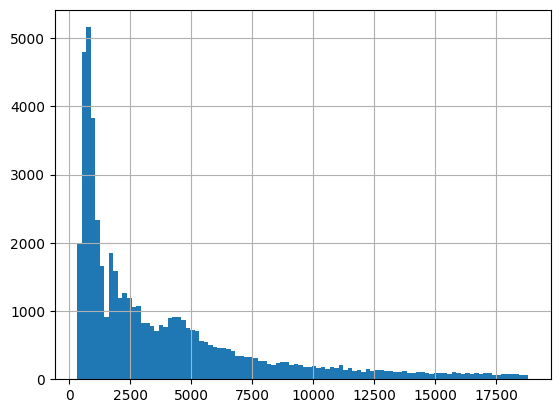

In [120]:
plt.hist(diamonds_df["price"], bins=100)
plt.grid()

# Подготовка данных

In [121]:
features = ['carat', 'cut', 'color',
            'clarity', 'depth', 'table', 'x', 'y', 'z']
target = ['price']

In [122]:
cut_transform = {'Fair': 0, 'Good': 1,
                 'Very Good': 2, 'Premium': 3, 'Ideal': 4}
clarity_transform = {'I1': 0, 'SI2': 1, 'SI1': 2,
                     'VS2': 3, 'VS1': 4, 'VVS2': 5, 'VVS1': 6, 'IF': 7}
color_transorm = {'D': 0, 'E': 1, 'F': 2, 'G': 3, 'H': 4, 'I': 5, 'J': 6}

In [123]:
diamonds_df['cut'] = diamonds_df['cut'].apply(lambda x: cut_transform.get(x))
diamonds_df['color'] = diamonds_df['color'].apply(
    lambda x: color_transorm.get(x))
diamonds_df['clarity'] = diamonds_df['clarity'].apply(
    lambda x: clarity_transform.get(x))

In [124]:
X = diamonds_df[features].copy().values
y = diamonds_df[target].values

In [125]:
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [126]:
X_train, X_test, y_train, y_test = train_test_split(
    X, y, random_state=47, test_size=0.3
)

# Обучаем модель линейной регрессии

In [127]:
reg = LinearRegression().fit(X_train, y_train)

In [158]:
reg.coef_

array([[51148.25187875,   472.47472887, -1974.69216261,  3530.7720608 ,
        -2988.69603069, -1478.39047474, -8721.95669848,  1098.0443115 ,
         -324.00144698]])

In [159]:
reg.intercept_

array([3097.9991962])

In [128]:
y_pred = reg.predict(X_test)

In [129]:
score = r2_score(y_pred, y_test)

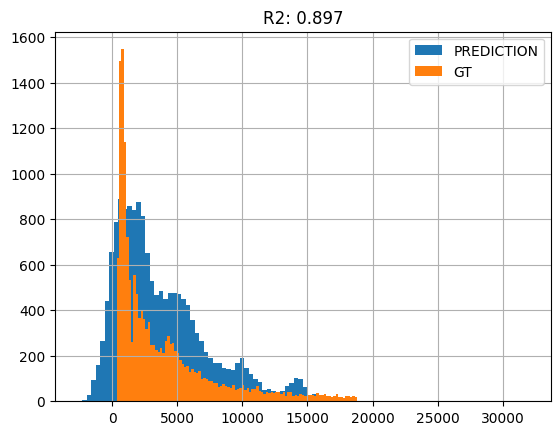

In [130]:
plt.title(f"R2: {str(score)[:5]}")
plt.hist(y_pred.reshape(1, -1)[0], bins=100, label="PREDICTION")
plt.hist(y_test.reshape(1, -1)[0], bins=100, label="GT")
plt.legend()
plt.grid()

# Создаём модель MLP для задачи регрессии

In [131]:
class Activation:
    def forward(self, inp: np.ndarray) -> np.ndarray:
        pass

    def backward(self, inp: np.ndarray) -> np.ndarray:
        pass


class Linear(Activation):
    def forward(self, inp: np.ndarray) -> np.ndarray:
        return inp

    def backward(self, inp: np.ndarray) -> np.ndarray:
        return 1


class LeakedReLu(Activation):
    def __init__(self, alpha: float):
        self.alpha = alpha

    def forward(self, x: np.ndarray) -> np.ndarray:
        return np.where(x > 0, x, self.alpha * x)

    def backward(self, x: np.ndarray) -> np.ndarray:
        return np.where(x > 0, 1, self.alpha)


class Sigmoid(Activation):
    def forward(self, x: np.ndarray) -> np.ndarray:
        return self._sigmoid(x)

    def backward(self, x: np.ndarray) -> np.ndarray:
        return self._sigmoid(x) * (1 - self._sigmoid(x))

    def _sigmoid(self, x: np.ndarray) -> np.ndarray:
        return 1.0 / (1.0 + np.exp(-x))

In [132]:
class Layer:
    def __init__(
        self, prev_size: int, size: int, learning_rate: float, activation: Activation
    ):
        self.learning_rate = learning_rate
        self.biases = np.random.rand(size).reshape(-1, 1) / 10
        if prev_size is not None and prev_size != 0:
            self.weights = np.random.rand(size, prev_size) / 10

        self._activation = activation

    def forward(self, input: np.ndarray) -> np.ndarray:
        if input.ndim == 0:
            self.neurons_input = self.weights * input + self.biases
        else:
            self.neurons_input = self.weights @ input + self.biases
        return self._activation.forward(self.neurons_input)

    def backward_with_update(
        self, error: np.ndarray, prev_out: np.ndarray
    ) -> np.ndarray:
        dl_dout = error.reshape(-1, 1)
        limit = 1
        dl_dout = np.where(dl_dout < limit, dl_dout, limit)
        dl_dout = np.where(dl_dout > -limit, dl_dout, -limit)

        neurons_backward = dl_dout * self._activation.backward(self.neurons_input)
        neurons_backward = neurons_backward.reshape(-1)

        dl_dw = np.outer(neurons_backward, prev_out)
        dl_db = neurons_backward

        dl_dout = self.weights.T @ neurons_backward

        self.weights -= self.learning_rate * dl_dw
        self.biases -= self.learning_rate * dl_db.reshape(-1, 1)

        return dl_dout

In [144]:
class MLPRegressor:
    def __init__(
        self,
        hidden_layer_sizes: tuple = (100,),
        learning_rate: float = 0.001,
        max_iter: int = 10,
        activation: Activation = Sigmoid(),
    ):
        self._learning_rate = learning_rate
        self._max_iter = max_iter

        self._layers = []

        self._input_size = None
        self._output_size = None

        self._layers.append(
            Layer(None, hidden_layer_sizes[0], learning_rate, activation)
        )
        for prev_size, curr_size in zip(hidden_layer_sizes, hidden_layer_sizes[1:]):
            self._layers.append(
                Layer(prev_size, curr_size, learning_rate, activation))

        self._loss = lambda actual, predicted: (actual - predicted) ** 2
        self._loss_derivative = lambda actual, predicted: - \
            2 * (actual - predicted)

    def train(self, x: np.ndarray, y: np.ndarray):
        if self._input_size is not None:
            if x.ndim == 1:
                assert (
                    self._input_size == 1
                ), "Input size differs from its previous value!"
            else:
                assert (
                    self._input_size == x.shape[-1]
                ), "Input size differs from its previous value!"
            if y.ndim == 1:
                assert (
                    self._output_size == 1
                ), "output size differs from its previous value!"
            else:
                assert (
                    self._output_size == y.shape[-1]
                ), "output size differs from its previous value!"
        else:
            self._init_knowing_sizes(x, y)

        self._x_norm_coef = x.mean()
        x = x / self._x_norm_coef

        self._y_norm_coef = y.mean()
        y = y / self._y_norm_coef

        losses = []
        for epoch in range(self._max_iter):
            i = 0
            for inp, actual in zip(x, y):
                predicted = self._forward(inp, True)
                loss = self._loss(actual, predicted)
                self._update_weights(actual, predicted)
                i += 1
                if i % (x.shape[0] / 10) == 0:
                    losses.append(loss)

        return losses

    def predict(self, x: np.ndarray):
        assert self._input_size is not None, "Neural network must be trained first!"
        if x.ndim == 1:
            assert (
                self._input_size == 1
            ), """Input size differs from training! 
                    current = 1, during training = {self._input_size}"""
        else:
            assert (
                self._input_size == x.shape[-1]
            ), """Input size differs from training! 
                    current = {x.shape[-1]}, during training = {self._input_size}"""

        x /= self._x_norm_coef

        result = []
        if x.ndim == 2 or (x.ndim == 1 and self._input_size == 1):
            for inp in x:
                result.append(self._forward(inp))
        else:
            result = self._forward(x)

        return np.array(result) * self._y_norm_coef

    def _forward(self, single_input: np.ndarray, train: bool = False) -> np.ndarray:
        assert single_input.ndim == 1 or single_input.ndim == 0

        if train:
            self._neurons_outputs = [single_input]

        last_layer_out = single_input.reshape(-1, 1)

        for layer in self._layers:
            last_layer_out = layer.forward(last_layer_out)
            if train:
                self._neurons_outputs.append(last_layer_out)

        return last_layer_out.reshape(-1)

    def _update_weights(self, actual: np.ndarray, predicted: np.ndarray) -> None:
        dl_dout = self._loss_derivative(actual, predicted)

        for i in range(len(self._layers) - 1, -1, -1):
            dl_dout = self._layers[i].backward_with_update(
                dl_dout, self._neurons_outputs[i]
            )

    def _init_knowing_sizes(self, x: np.ndarray, y: np.ndarray) -> None:
        if x.ndim == 1:
            self._input_size = 1
        else:
            self._input_size = x.shape[1]
        first_layer_size = self._layers[0].biases.size
        self._layers[0].weights = (
            np.random.rand(first_layer_size, self._input_size) / 10
        )

        if y.ndim == 1:
            self._output_size = 1
        else:
            self._output_size = y.shape[1]
        last_layer_size = self._layers[-1].biases.size
        self._layers.append(
            Layer(last_layer_size, self._output_size,
                  self._learning_rate, Linear())
        )

# Обучаем модель MLP на выборке Diamonds

In [145]:
my_nn = MLPRegressor((100, 30), max_iter=5)

In [154]:
losses = my_nn.train(X_train, y_train)

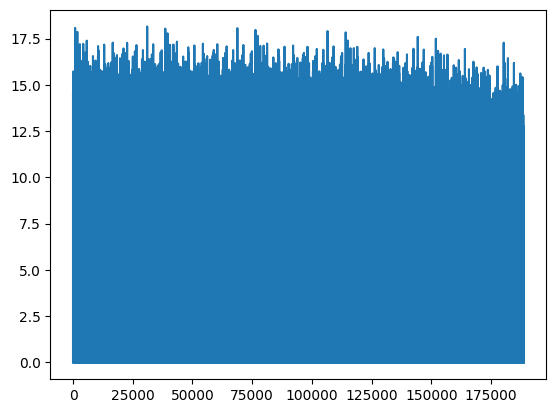

In [155]:
plt.plot(np.array(losses)[:, 0])

# Проверяем модель MLP на выборке Diamonds

In [149]:
my_pred = my_nn.predict(X_test)
my_score = r2_score(my_pred, y_test)

In [151]:
my_pred

array([[2206.10923138],
       [2218.06107103],
       [2194.44468106],
       ...,
       [2213.94347568],
       [2220.4557059 ],
       [2204.77905047]])

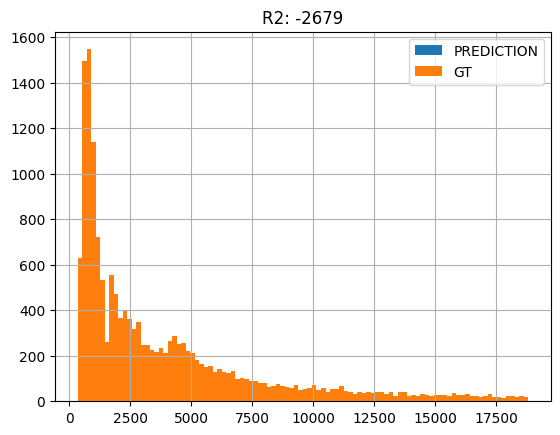

In [153]:
plt.title(f"R2: {str(my_score)[:5]}")
plt.hist(my_pred.reshape(1, -1)[0], bins=100, label="PREDICTION")
plt.hist(y_test.reshape(1, -1)[0], bins=100, label="GT")
plt.legend()
plt.grid()

# my test

In [136]:
nn_test = MLPRegressor((100, 30), max_iter=5)

In [137]:
my_x = np.linspace((0, 0), (1000, 1000), 100)
my_y = my_x * my_x + 2 * my_x + 1

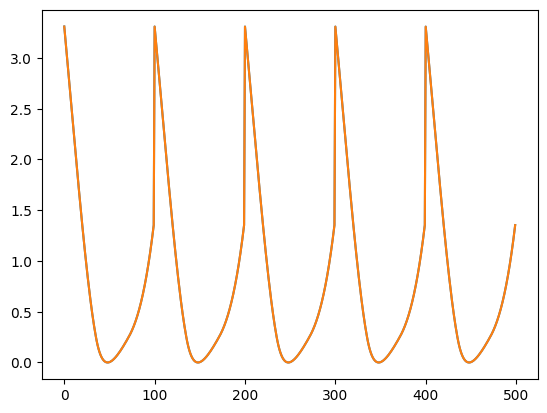

ValueError: x, y, and format string must not be None

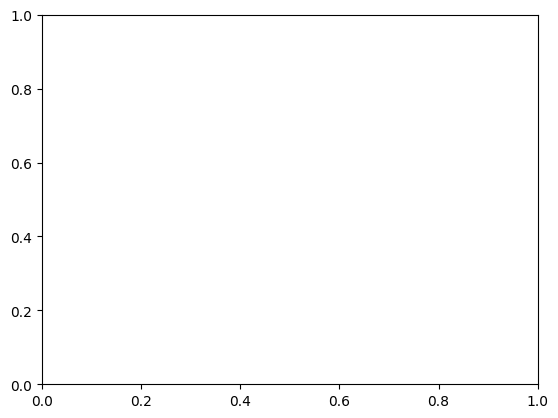

In [141]:
ll = nn_test.train(my_x, my_y)
plt.plot(np.array(ll)[:, 0])
plt.plot(np.array(ll)[:, 1])
plt.ylim((0, 1e7))

In [ ]:
nn_test._layers[0].weights

array([[nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan, nan],
       [nan,